<a href="https://colab.research.google.com/github/lsaif/FaciesPercentage/blob/main/FaciesPercentage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Facies Percentage**

These codes below allow you to determine lithology based on log conditions and calculate its lithology percentage for each interval. It is free for you to input LAS file or directly use a preconditioned data which already has a lithology log. A function to enable multi-well analysis and improve the flexibility is still under development.

####**Flowchart**
This is the workflow

![Flowchart](https://drive.google.com/uc?id=1LGszma_EOvzcBFUyQMc1GAfu9AvgMjN1)



####**Import Dependencies and Build Functions**

Please run these 3 column of codes to enable all funtions required to calculate facies percentage

In [ ]:
# Install lasio (required)
!pip install lasio

In [ ]:
#Mount your google drive directory, you don't need to do this if you use your local machine.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all dependencies and stretch the data limit
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import lasio

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

#Function to add your lasfile and embed the tops of intervals
#source_dir = directory of your data
#lasfile = LAS file name
#topsfile = Tops data file name
def InputWell(source_dir,lasfile, topsfile):
  #Import your LAS file and convert it to a dataframe
  l = lasio.read(f"{source_dir}/{lasfile}")
  data = l.df()
  data = data.replace('-999.00000',np.nan)
  data.index.names = ['DEPT']
  well = l.well.WELL.value    #This contain your well name
  data['WELL'] = well         #This contain your log data

  #Import your tops of interval
  tops = pd.read_csv(f"{source_dir}/{topsfile}", sep='\t')
  tops_unit = tops['ROCK UNIT'].unique()    #This contain list of interval, adjust the column name to suit yours
  
  #Assign interval name to each point in your log data
  data_well = pd.DataFrame()
  for i in range(len(tops_unit)):
    top = tops.iloc[i]['DEPTH']
    if i < len(tops_unit)-1:
      bottom = tops.iloc[i+1]['DEPTH']
    else:
      bottom = int(round(data.tail(1).index.item()))
    data_interval = data.iloc[top:bottom, :]
    data_interval['INTERVAL'] = tops.iloc[i]['ROCK UNIT']
    data_well = data_well.append(data_interval)
  data = data_well

  return well,data

#Function to determine lithology based on several conditions
#data = your log data
#gr = column number of GR log in your data
#rhob = column number of RHOB log in your data
def DetermineLithology (data, gr, rhob):
  GR = data.iloc[:,gr]
  RHOB = data.iloc[:,rhob]

  #each condition refer to its lithology in following order, adjust to your specifications
  conditions = [
    (GR <=55) & (RHOB >= 2.71),
    (GR <=55) & (RHOB >= 2.65),
    (GR <=55) & (RHOB > 1.8),
    (GR <=55) & (RHOB < 1.8),
    (GR <=80),
    (GR >=80)]
  lithology = ['Dolomite', 'Limestone', 'Sandstone', 'Coal', 'Siltstone', 'Shale']
  data['LITHOLOGY'] = np.select(conditions, lithology, default='Undefined')
  return data

#Function to calculate facies percentage for multiwell
#data = your log data which already contain well name, interval name, and lithology each as a column
def CalculatePercentage(data):
  data_well = pd.DataFrame()
  data_interval = pd.DataFrame()
  F_well = pd.DataFrame()
  Facies = pd.DataFrame()

  for i in range(len(well)):
    data_well=data.where(data['WELL']==well[i]).dropna()
    interval = data_well['INTERVAL'].unique()
    for j in range (len(interval)):
      data_interval=data_well.where(data_well['INTERVAL']==interval[j]).dropna()
      F_percent = data_interval['LITHOLOGY'].value_counts(normalize=True) * 100
      F_percent = F_percent.sort_index()
      F_percent['INTERVAL'] = interval[j]
      F_percent= pd.DataFrame(F_percent).transpose()
      F_well = F_well.append(F_percent)
    F_well['WELL'] = well[i]
    F_well = F_well.set_index('WELL')
    Facies = Facies.append(F_well)
    F_well = pd.DataFrame()
  
  Facies = Facies.reset_index()
  Facies = Facies.fillna(0)
  return Facies

#Function to calculate facies percentage for single well
#well = your well name
#data = your log data which already contain well name, interval name, and lithology each as a column
def CalculatePercentageSingleWell(well, data):
  data_well = pd.DataFrame()
  data_interval = pd.DataFrame()
  F_well = pd.DataFrame()
  Facies = pd.DataFrame()
  tops_unit = data['INTERVAL'].unique()

  for i in range (len(tops_unit)):
      data_interval=data.where(data['INTERVAL']==tops_unit[i]).dropna()
      F_percent = data_interval['LITHOLOGY'].value_counts(normalize=True) * 100
      F_percent = F_percent.sort_index()
      F_percent['INTERVAL'] = tops_unit[i]
      F_percent= pd.DataFrame(F_percent).transpose()
      F_well = F_well.append(F_percent)
  F_well['WELL'] = well
  Facies = Facies.append(F_well)
  F_well = pd.DataFrame()
  
  Facies = Facies.reset_index()
  Facies = Facies.fillna(0)
  return Facies

#Function to display a horizontal barchart of your calculated facies percentage
def PlotBarChart(well):
  facies_well = Facies#.where(Facies['WELL']==well)
  interval = facies_well['INTERVAL'].unique()
  
  facies_well.plot.barh(stacked=True)
  plt.yticks(range(len(interval)), interval)
  plt.gca().invert_yaxis()
  plt.ylabel("Formation")
  plt.xlabel("Facies Percentage")
  plt.title(well)
  plt.legend(bbox_to_anchor=(1.1, 1.05))

####**Run the code**

This is where you actually apply the function to your data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


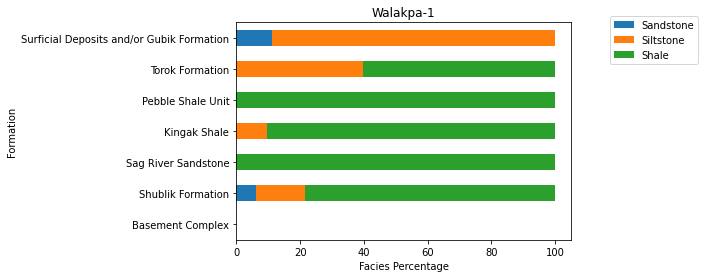

In [ ]:
#Set your source data directory, LAS file name, Tops of interval, and output file
source_dir ='/content/drive/MyDrive/[2020] Genting/WellAlaska'
lasfile = 'WA1.LAS'
topsfile = 'WA1TOPS.txt'
outfile = 'FaciesPercentage.csv'

well, data = InputWell(source_dir,lasfile,topsfile)
data = DetermineLithology(data,1,7)
Facies = CalculatePercentageSingleWell(well, data)
Facies.to_csv(outfile)
PlotBarChart('Walakpa-1')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
